In [1]:
import sys

sys.path.append("..")

In [10]:
import sys

sys.path.append("..")

import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

import os
from functools import lru_cache
from typing import Callable, List, Tuple, Union

import cv2

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import (
    clean_state_dict,
    get_phrases_from_posmap,
)
from PIL import Image

from segment.sam_results import format_boxes, format_scores
from segment.utils import get_device, image_handler, load_resize_image
from segment.visualizer import display_image_with_masks_and_boxes
from typing import Union
from transformers import PreTrainedTokenizerBase

DEVICE = get_device()

# CURDIR = os.path.dirname(__file__)
# jupyter
CURDIR = os.getcwd()

WEIGHTS_DIR = os.path.join(CURDIR, "..", "weights")

# Dino
DINO_DIR = os.path.join(CURDIR, "..", "GroundingDINO")
DINO_CHECKPOINT = os.path.join(WEIGHTS_DIR, "groundingdino_swint_ogc.pth")
DINO_CONFIG = os.path.join(DINO_DIR, "groundingdino/config/GroundingDINO_SwinT_OGC.py")


def text_prompt_handler(text_prompt: str, images: torch.Tensor) -> List[str]:
    """
    Process a single text_prompt for multiple images represented as a tensor.

    Args:
    text_prompt (str): The text_prompt to be processed.
    images (torch.Tensor): A tensor of images.

    Returns:
    List[str]: A list of processed text_prompts, one for each image in the tensor.

    Raises:
    ValueError: If the text_prompt is empty or images tensor is empty.
    TypeError: If images is not a torch.Tensor.
    """
    if not text_prompt:
        raise ValueError("text_prompt cannot be empty.")
    if not isinstance(images, torch.Tensor):
        raise TypeError("Images must be a torch.Tensor.")
    if images.numel() == 0:
        raise ValueError("Images tensor cannot be empty.")

    processed_text_prompt = text_prompt.lower().strip()
    if not processed_text_prompt.endswith("."):
        processed_text_prompt += "."

    num_images = images.size(0)  # Assuming the first dimension is the number of images
    return [processed_text_prompt] * num_images

@lru_cache(maxsize=1)
def get_text_prompt_split(text_prompt: str, splitter: str = ".") -> List[str]:
    return text_prompt.split(splitter)
        
def get_prompt_from_token(
    tokenized: PreTrainedTokenizerBase,
    text_prompt: str,
    target_input_id: int,
    splitter: str = ".",
) -> str:
    """
    Retrieve the full phrase containing a specific token from a tokenized text prompt.

    This function takes a tokenized text prompt and finds the original full phrase
    that contains the token corresponding to the given input ID.

    Args:
        tokenized (PreTrainedTokenizerBase): The tokenized output from the tokenizer,
                                             which should include offset_mapping.
        text_prompt (str): The full text prompt that was tokenized.
        target_input_id (int): The input ID of the token to search for.
        splitter (str, optional): The character used to split the text_prompt into phrases.
                                  Defaults to '.'.

    Returns:
        str: The full phrase containing the target token, or an error message if not found.

    Raises:
        AttributeError: If the tokenized input doesn't have the required attributes.

    Example:
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        text_prompt = "This is a sentence. This is another one."
        tokenized = tokenizer(text_prompt, return_offsets_mapping=True)
        result = get_prompt_from_token(tokenized, text_prompt, tokenized.input_ids[5])
    """
    # Find the index of the target input_id
    try:
        target_index = tokenized.input_ids.index(target_input_id)
    except ValueError:
        return f"Input ID {target_input_id} not found in the tokenized text."

    # Get the character start and end positions for the target token
    start, end = tokenized.offset_mapping[target_index]

    # Find which phrase the token belongs to
    current_position = 0
    text_prompt_split = get_text_prompt_split(text_prompt, splitter)
    for phrase in text_prompt_split:
        phrase_end = current_position + len(phrase)
        if current_position <= start < phrase_end:
            return phrase.strip()
        current_position = phrase_end + len(splitter)

    return "Phrase not found"


@lru_cache(maxsize=1)
def load_dino_model(
    config_path: str = DINO_CONFIG,
    checkpoint_path: str = DINO_CHECKPOINT,
    device: torch.device = DEVICE,
) -> torch.nn.Module:
    """
    Load and initialize the grounding model, using caching to avoid reloading.

    Args:
        config_path (str): Path to the model configuration file.
        checkpoint_path (str): Path to the model checkpoint file.
        device (torch.device): Device to load the model onto.

    Returns:
        torch.nn.Module: The loaded and initialized model.
    """
    args = SLConfig.fromfile(config_path)
    args.device = device

    model = build_model(args)
    checkpoint = torch.load(checkpoint_path, map_location="cpu")

    load_result = model.load_state_dict(
        clean_state_dict(checkpoint["model"]), strict=False
    )
    print(f"Model loading result: {load_result}")

    model.eval()
    return model.to(device)


dino_transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def transform_image_dino(image_pil: Image.Image) -> torch.tensor:
    image, _ = dino_transform(image_pil, None)  # 3, h, w
    return image

@lru_cache(maxsize=1)
def tokenize_prompt(text_prompt: str, tokenizer: PreTrainedTokenizerBase) -> torch.tensor:
    return tokenizer(text_prompt, return_offsets_mapping=True)
    
# def run_dino(
#     dino_model: Callable,
#     images: torch.tensor,
#     text_prompt: str,
#     box_threshold: float = 0.3,
#     text_threshold: int = 0.25,
#     **kwargs,
# ) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[List[str]]]:

#     processed_text_prompts = text_prompt_handler(text_prompt, images)

#     # Ensure images is a batch (first dimension is batch size)
#     images = images.unsqueeze(0) if len(images.shape) == 3 else images

#     with torch.no_grad():
#         outputs = dino_model(images, captions=processed_text_prompts)

#     prediction_logits = outputs["pred_logits"].cpu().sigmoid()
#     prediction_boxes = outputs["pred_boxes"].cpu()

#     mask = prediction_logits.max(dim=2)[0] > box_threshold

#     tokenizer = dino_model.tokenizer
#     tokenized = tokenize_prompt(text_prompt, tokenizer)

#     # Vectorized operations
#     batch_logits = [logits[m] for logits, m in zip(prediction_logits, mask)]

#     batch_boxes = [boxes[m] for boxes, m in zip(prediction_boxes, mask)]

#     # Compute max logits once
#     max_logits = [logits.max(dim=1) for logits in batch_logits]

#     filtered_batch_boxes = []
#     filtered_predicts_batch = []
#     filtered_prompt_tokens_batch = []
#     filtered_text_prompt_batch = []

#     for batch_logit, max_logit, boxes in zip(batch_logits, max_logits, batch_boxes):
#         logit_mask = max_logit.values > text_threshold
#         filtered_batch_boxes.append(boxes[logit_mask])
#         filtered_predicts_batch.append(max_logit.values[logit_mask])

#         # Get the prompt token most correlated with the object
#         filtered_prompt_tokens = [
#             get_phrases_from_posmap(logit == max_val, tokenized, tokenizer).replace(
#                 ".", ""
#             )
#             for logit, max_val in zip(
#                 batch_logit[logit_mask], max_logit.values[logit_mask]
#             )
#         ]
#         filtered_prompt_tokens_batch.append(filtered_prompt_tokens)

#         # Get the full prompt most correlated with the object
#         filtered_text_prompts = [
#             get_prompt_from_token(
#                 tokenized,
#                 text_prompt,
#                 tokenized.input_ids[max_val.item()],
#                 splitter=".",
#             )
#             for max_val in max_logit.indices[logit_mask]
#         ]

#         filtered_text_prompt_batch.append(filtered_text_prompts)
#     return (
#         filtered_batch_boxes,
#         filtered_predicts_batch,
#         filtered_prompt_tokens_batch,
#         filtered_text_prompt_batch,
#     )

def run_dino(
    dino_model: Callable,
    images: torch.tensor,
    text_prompt: str,
    box_threshold: float = 0.3,
    text_threshold: float = 0.25,
    **kwargs,
) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[List[str]], List[List[str]]]:

    processed_text_prompts = text_prompt_handler(text_prompt, images)

    # Ensure images is a batch (first dimension is batch size)
    images = images.unsqueeze(0) if len(images.shape) == 3 else images

    with torch.no_grad():
        outputs = dino_model(images, captions=processed_text_prompts)

    prediction_logits = outputs["pred_logits"].cpu().sigmoid()
    prediction_boxes = outputs["pred_boxes"].cpu()

    mask = prediction_logits.max(dim=2)[0] > box_threshold

    tokenizer = dino_model.tokenizer
    tokenized = tokenize_prompt(text_prompt, tokenizer)

    batch_results = []

    for logits, boxes, m in zip(prediction_logits, prediction_boxes, mask):
        filtered_logits = logits[m]
        filtered_boxes = boxes[m]
        
        max_logits, max_indices = filtered_logits.max(dim=1)
        logit_mask = max_logits > text_threshold

        batch_result = {
            'boxes': filtered_boxes[logit_mask],
            'scores': max_logits[logit_mask],
            'prompt_tokens': [
                get_phrases_from_posmap(logit == max_val, tokenized, tokenizer).replace(".", "")
                for logit, max_val in zip(filtered_logits[logit_mask], max_logits[logit_mask])
            ],
            'text_prompts': [
                get_prompt_from_token(
                    tokenized,
                    text_prompt,
                    tokenized.input_ids[max_idx.item()],
                    splitter=".",
                )
                for max_idx in max_indices[logit_mask]
            ]
        }
        batch_results.append(batch_result)

    return (
        [result['boxes'] for result in batch_results],
        [result['scores'] for result in batch_results],
        [result['prompt_tokens'] for result in batch_results],
        [result['text_prompts'] for result in batch_results]
    )


def format_dino(
    batch_boxes_filt,
    batch_scores,
    batch_pred_prompt_tokens,
    batch_pred_text_prompts,
    image_size=(1024, 1024),
    iou_threshold=0.8,
):
    batch_final_boxes = []
    batch_final_scores = []
    batch_final_prompt_tokens = []
    batch_final_text_prompt = []

    # Process each item in the batch
    for (
        boxes_filt,
        scores,
        pred_prompt_tokens,
        pred_prompt,
    ) in zip(
        batch_boxes_filt,
        batch_scores,
        batch_pred_prompt_tokens,
        batch_pred_text_prompts,
    ):
        # Adjust box coordinates based on image size
        H, W = image_size[1], image_size[0]
        for i in range(boxes_filt.size(0)):
            boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
            boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
            boxes_filt[i][2:] += boxes_filt[i][:2]

        # Non-maximum suppression (NMS)
        nms_idx = (
            torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
        )
        final_boxes = boxes_filt[nms_idx]
        final_scores = scores[nms_idx]
        final_prompt_tokens = [pred_prompt_tokens[idx] for idx in nms_idx]
        final_text_prompt = [pred_prompt[idx] for idx in nms_idx]

        # Collect results for this batch element
        batch_final_boxes.append(final_boxes)
        batch_final_scores.append(final_scores)
        batch_final_prompt_tokens.append(final_prompt_tokens)
        batch_final_text_prompt.append(final_text_prompt)

    return (
        batch_final_boxes,
        batch_final_scores,
        batch_final_prompt_tokens,
        batch_final_text_prompt,
    )


class DinoDetector:
    """
    A class for detecting and highlighting objects in images using the DINO (Detection Transformer) model.

    This class can process images from various input formats, detect objects based on a text prompt,
    and display the results.

    Attributes:
        image_size (int): The size to which input images will be resized (default: 1024).
        device (torch.device): The device on which computations will be performed.
        images (List[Image.Image]): List of PIL Image objects to be processed.
        dino_images (torch.Tensor): Tensor of transformed images ready for DINO model input.
        text_prompt (str): A string of words to detect, separated by periods.
        model: The loaded DINO model.
        box_threshold (float): Confidence threshold for bounding boxes (default: 0.3).
        text_threshold (float): Confidence threshold for text detection (default: 0.25).
        iou_threshold (float): Intersection over Union threshold for box merging (default: 0.8).
        boxes (torch.Tensor): Detected bounding boxes.
        scores (torch.Tensor): Confidence scores for detected boxes.
        prompt_tokens (List[str]): Detected prompt_tokens corresponding to boxes.

    Args:
        image (Union[str, Image.Image, List[Image.Image]]): Input image(s) as file path, PIL Image, or list of PIL Images.
        text_prompt (str): A string of words to detect, separated by periods.
        image_size (int, optional): Size to resize input images (default: 1024).
        box_threshold (float, optional): Confidence threshold for bounding boxes (default: 0.3).
        text_threshold (float, optional): Confidence threshold for text detection (default: 0.25).
        iou_threshold (float, optional): Intersection over Union threshold for box merging (default: 0.8).

    Example:
        im_path = "https://i.pinimg.com/originals/68/82/ce/6882cefe21f75234697e8508eb6a3232.jpg"
        text_prompt = ["hair", "face", "neck", "arm", "hand", "back", "leg", "clothing", "phone", "hat", "foot"]
        text_prompt = ".".join(text_prompt)

        detector = DinoDetector(im_path, text_prompt)
        detector.run()
        detector.display_results()
    """

    def __init__(
        self,
        image: Union[str, Image.Image, List[Image.Image]],
        text_prompt: str,
        transform: Callable = transform_image_dino,
        image_size: int = 1024,
        box_threshold: float = 0.3,
        text_threshold: float = 0.25,
        iou_threshold: float = 0.8,
    ):
        self.image_size = image_size
        self.device = DEVICE
        self.images = image_handler(image, self.image_size)
        self.transform = transform
        self.dino_images = self.image_to_tensor()
        self.text_prompt = text_prompt
        self.processed_text_prompt = self._process_text_prompts(self.text_prompt)
        self.model = self._load_dino_model()
        self.box_threshold = box_threshold
        self.text_threshold = text_threshold
        self.iou_threshold = iou_threshold
        self.boxes = None
        self.scores = None
        self.prompt_tokens = None
        self.pred_prompt = None

    def _load_dino_model(self):
        return load_dino_model()

    def image_to_tensor(self):
        with torch.no_grad():
            dino_images = torch.stack([self.transform(image) for image in self.images])
        return dino_images.to(self.device)

    def _process_text_prompts(self, text_prompt: str) -> List[str]:
        return text_prompt_handler(text_prompt, self.dino_images)

    def run(self):
        self.boxes, self.scores, self.prompt_tokens, self.pred_prompt = run_dino(
            self.model,
            self.dino_images,
            self.text_prompt,
            self.box_threshold,
            self.text_threshold,
        )

        self.boxes, self.scores, self.prompt_tokens, self.pred_prompt = (
            format_dino(
                self.boxes,
                self.scores,
                self.prompt_tokens,
                self.pred_prompt,
                (self.image_size, self.image_size),
                self.iou_threshold,
            )
        )

    def asdict(self, image_num=0):
        boxes = format_boxes(self.boxes[image_num])
        scores = format_scores(self.scores[image_num])
        prompt_tokens = self.prompt_tokens[image_num]
        text_prompt = self.pred_prompt[image_num]
        return [
            dict(
                box=box,
                score=score,
                label=prompt_tokens[idx],
                text_prompt=text_prompt[idx],
            )
            for idx, (box, score) in enumerate(zip(boxes, scores))
        ]

    def display_results(
        self,
        image_num=0,
        cols: int = 4,
        **kwargs,
    ):
        # Convert PIL Image to numpy array
        display_image_with_masks_and_boxes(
            self.images[image_num], self.asdict(image_num=image_num), cols=cols, **kwargs
        )


final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


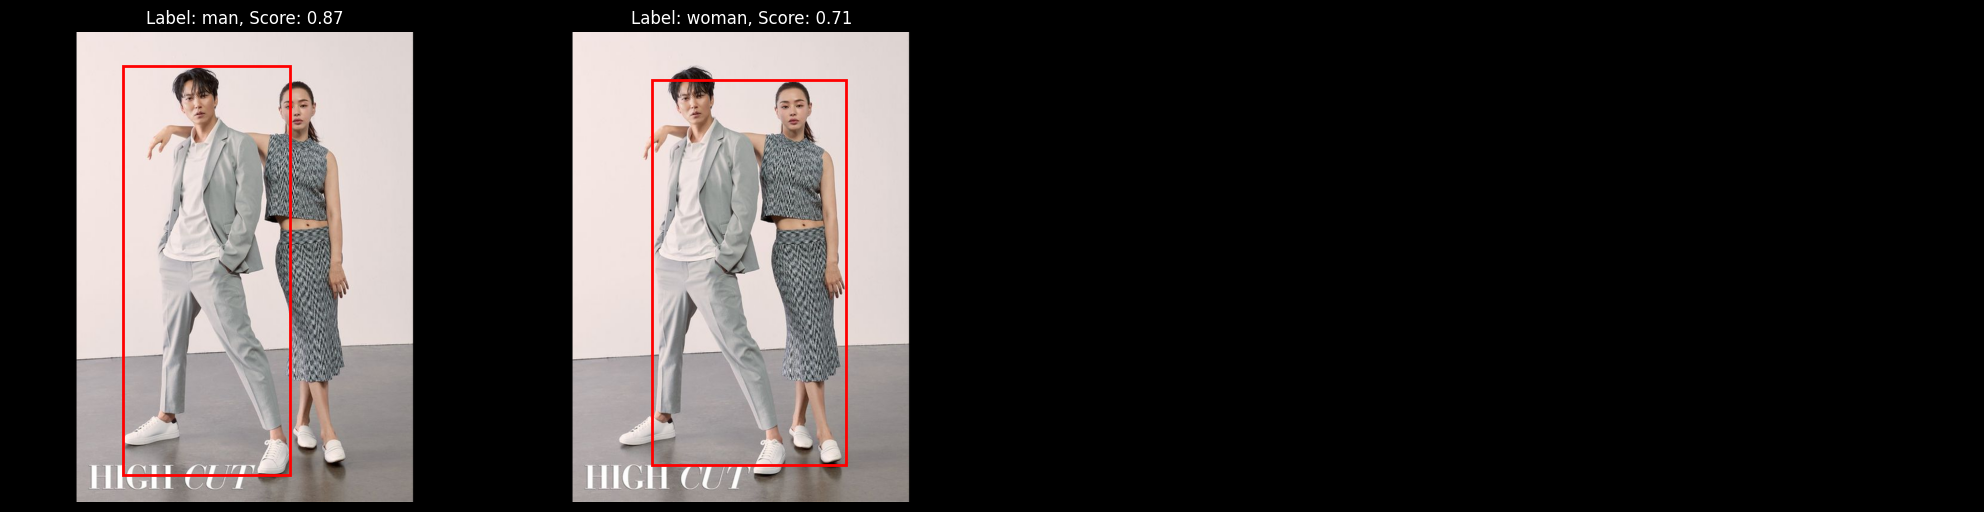

In [11]:
# images
im_path1 = "https://i.pinimg.com/564x/58/c2/46/58c2468a13fca033b29a35ec6601d315.jpg"
im_path2 = 'https://i.pinimg.com/564x/7e/61/b6/7e61b6cce1752f2e89f130996bfe122e.jpg'

images = [load_resize_image(im) for im in [im_path1, im_path2]]

text_prompt_list = [
    "hair",
    "face hair",
    "her neck",
    "arm",
    "her hands",
    "back",
    "leg",
    "her clothing",
    "foot",
    "phone",
    "hat",
    "shoe",
    "his collar",
    "dove"
]

text_prompt_list = ['man', 'woman']

text_prompt = ".".join(text_prompt_list)

detector = DinoDetector(images, text_prompt, image_size=846, box_threshold=0.3, text_threshold=0.3, iou_threshold=0.8)

detector.run()

detector.display_results(prompt_label="text_prompt")

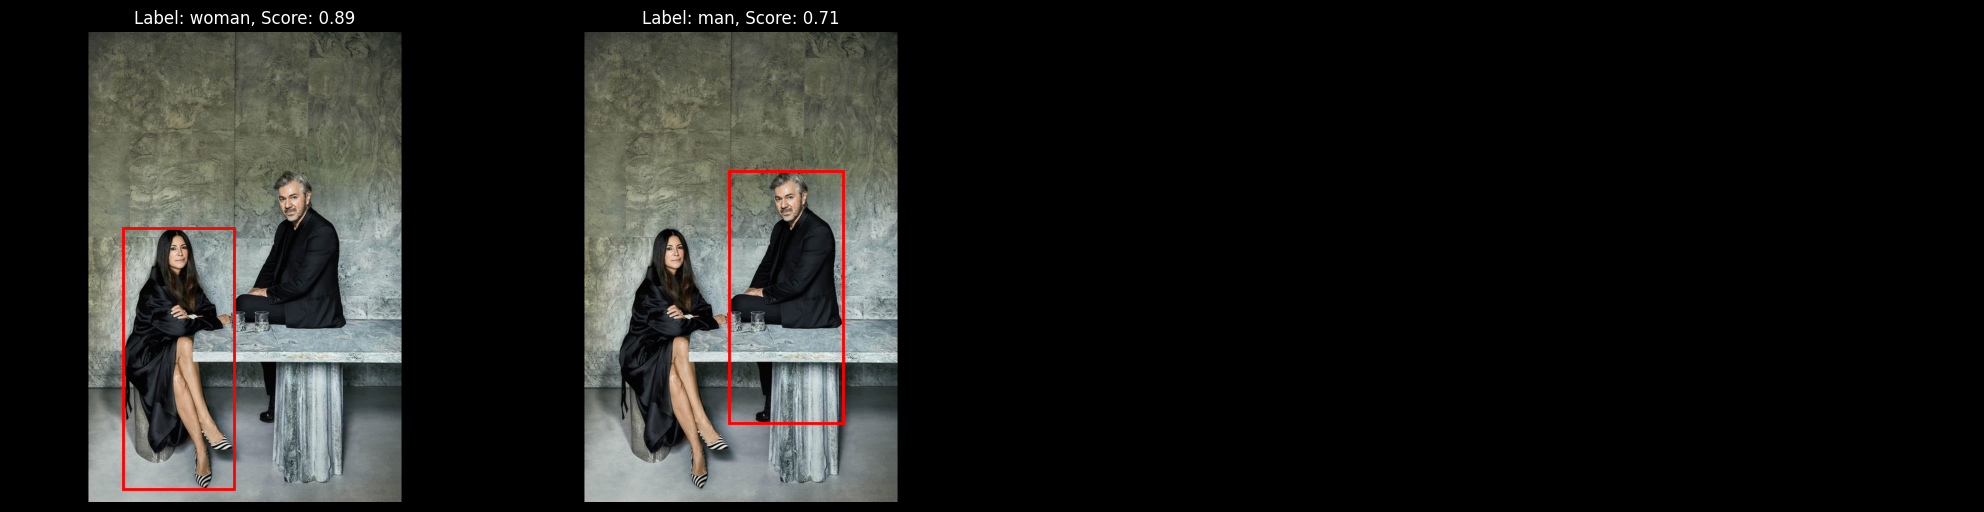

In [12]:
detector.display_results(image_num=1, prompt_label="text_prompt")

In [14]:
detector.boxes

[tensor([[202.0742,  60.8894, 504.2134, 797.6807],
         [261.4132,  85.5595, 610.7341, 778.5922]]),
 tensor([[202.9395, 352.1646, 402.5982, 822.6929],
         [400.1424, 249.2959, 605.1937, 703.9860]])]

: 